In [7]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

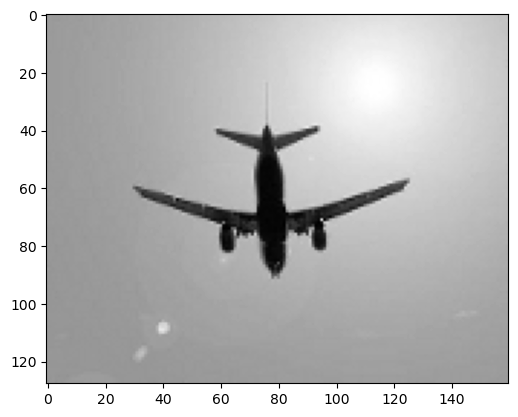

In [107]:
PATH = "E:\\Repo Scripts\\Level Set Codes\\Image\\1.jpg"
img = cv2.imread(PATH,0).astype(np.float32)
# plt.imshow(img,cmap='gray')

In [69]:
def Heaviside(phi,epsilon=1):
    H = 0.5*(1+ (2/np.pi)*np.arctan(phi/epsilon))
    return H
def Dirac(phi,epsilon=1):
    Delta_h=(epsilon/np.pi)/(epsilon**2+ phi**2)
    return Delta_h
def NeumannBoundCond(g):
    #Make a function satisfy Neumann boundary condition
    [nrow,ncol] = np.size(g)
    g[1, nrow][1, ncol] = g[3, nrow-2][3, ncol-2]
    # g[1, nrow],2:end-1) = g([3 nrow-2],2:end-1)
    # g(2:end-1,[1 ncol]) = g(2:end-1,[3 ncol-2])
    return g
def Calculate_c(Img,H_phi):
    a = H_phi*Img
    numer_1 = np.sum(a) 
    denom_1 = np.sum(H_phi)
    C1 = numer_1/denom_1

    b = (1-H_phi)*Img
    numer_2 = np.sum(b)
    c = 1-H_phi
    denom_2 = np.sum(c)
    C2 = numer_2/denom_2
    return C1,C2

In [10]:
epsilon = 1
lambda1 = 1 #inside
lambda2 = 1 #outside
mu = 1  #length
nu = 0  #area
epoch = 10

In [111]:
def evolveLSF(I,phi,epoch,epsilon=1,timestep = 0.1,lambda_1 = 1, lambda_2 = 1,nu=1):
    for i in range(epoch):
        # phi = NeumannBoundCond(phi)
        dirac_phi = Dirac(phi)
        H_phi=Heaviside(phi, epsilon)
        # kappa = CURVATURE(phi,'cc')
        [C1,C2]=Calculate_c(I,H_phi)
        # updating the phi function
        phi=phi+timestep*(dirac_phi*(nu-lambda_1*(I-C1)**2+lambda_2*(I-C2)**2))
    return phi


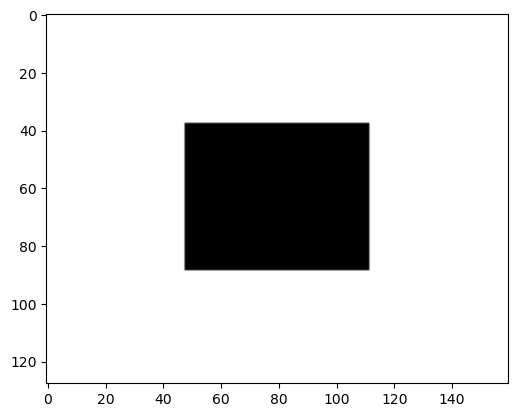

In [113]:
phi0 = np.ones((img.shape[0],img.shape[1]))
phi0[int(3*img.shape[0]/10):int(7*img.shape[0]/10),int(3*img.shape[1]/10):int(7*img.shape[1]/10)] = -1
plt.imshow(phi0,cmap='gray')

In [ ]:
phi = evolveLSF(img,phi0,1)
plt.imshow(phi,cmap='gray')